In [4]:
# import sys

# sys.path.append("../..")

# from pathlib import Path

# import seaborn as sns
# from PIL import Image

# from src.croco.models.croco import CroCoNet


# # !mkdir -p pretrained_models/
# # !wget https://download.europe.naverlabs.com/ComputerVision/CroCo/CroCo.pth -P pretrained_models/

In [5]:
import torch
import torchvision.transforms
from torchvision.transforms import Compose, Normalize, ToTensor

device = torch.device("cuda:0" if torch.cuda.is_available() and torch.cuda.device_count() > 0 else "cpu")

# load 224x224 images and transform them to tensor
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_mean_tensor = torch.tensor(imagenet_mean).view(1, 3, 1, 1).to(device, non_blocking=True)
imagenet_std = [0.229, 0.224, 0.225]
imagenet_std_tensor = torch.tensor(imagenet_std).view(1, 3, 1, 1).to(device, non_blocking=True)
trfs = Compose([ToTensor(), Normalize(mean=imagenet_mean, std=imagenet_std)])
image1 = trfs(Image.open("../assets/Chateau1.png").convert("RGB")).to(device, non_blocking=True).unsqueeze(0)
image2 = trfs(Image.open("../assets/Chateau2.png").convert("RGB")).to(device, non_blocking=True).unsqueeze(0)

# load model
ckpt = torch.load(Path.cwd() / "pretrained_models/CroCo.pth", "cpu")
model = CroCoNet(**ckpt.get("croco_kwargs", {})).to(device)
model.eval()
msg = model.load_state_dict(ckpt["model"], strict=True)

# forward
with torch.inference_mode():
    out, mask, target = model(image1, image2)

# the output is normalized, thus use the mean/std of the actual image to go back to RGB space
patchified = model.patchify(image1)
mean = patchified.mean(dim=-1, keepdim=True)
var = patchified.var(dim=-1, keepdim=True)
decoded_image = model.unpatchify(out * (var + 1.0e-6) ** 0.5 + mean)
# undo imagenet normalization, prepare masked image
decoded_image = decoded_image * imagenet_std_tensor + imagenet_mean_tensor
input_image = image1 * imagenet_std_tensor + imagenet_mean_tensor
ref_image = image2 * imagenet_std_tensor + imagenet_mean_tensor
image_masks = model.unpatchify(model.patchify(torch.ones_like(ref_image)) * mask[:, :, None])
masked_input_image = (1 - image_masks) * input_image

# make visualization
visualization = torch.cat(
    (ref_image, masked_input_image, decoded_image, input_image), dim=3
)  # 4*(B, 3, H, W) -> B, 3, H, W*4
B, C, H, W = visualization.shape
visualization = visualization.permute(1, 0, 2, 3).reshape(C, B * H, W)
visualization = torchvision.transforms.functional.to_pil_image(torch.clamp(visualization, 0, 1))
fname = "demo_output.png"
visualization.save(fname)
print("Visualization save in " + fname)

<!-- ### Patchify/Unpatchify -->

<!-- #### Implementation -->

In [6]:
# from src.annotated.patchify import patchify, unpatchify

<!-- #### Tests -->

In [7]:
# import torch


# def test_patchify_unpatchify_round_trip():
#     """
#     Test that unpatchify(patchify(imgs)) == imgs for random tensors.
#     """
#     print("Running Round-Trip Test...")
#     B, C, H, W = 2, 3, 128, 128  # Square images
#     patch_size = 32
#     imgs = torch.randn(B, C, H, W)

#     patches, num_patches_h, num_patches_w = patchify(imgs, patch_size)
#     reconstructed = unpatchify(patches, patch_size, num_patches_h, num_patches_w, channels=C)

#     assert torch.allclose(
#         imgs, reconstructed, atol=1e-6
#     ), "Round-trip patchify -> unpatchify failed for square images."
#     print("Round-Trip Test Passed for Square Images.")


# def test_patchify_unpatchify_specific_case():
#     """
#     Test patchify and unpatchify with a specific tensor where the outcome is known.
#     """
#     print("Running Specific Case Test...")
#     # Create a simple tensor where each pixel value is unique
#     B, C, H, W = 1, 1, 4, 6  # Non-square image
#     patch_size = 2
#     imgs = torch.arange(B * C * H * W).reshape(B, C, H, W).float()

#     # Expected patches:
#     # For H=4, W=6, patch_size=2 -> num_patches_h=2, num_patches_w=3
#     # Patches are ordered row-wise
#     # Patch 1: [[0, 1], [6, 7]]
#     # Patch 2: [[2, 3], [8, 9]]
#     # Patch 3: [[4, 5], [10,11]]
#     # Patch 4: [[12,13], [18,19]]
#     # Patch 5: [[14,15], [20,21]]
#     # Patch 6: [[16,17], [22,23]]
#     expected_patches = torch.tensor(
#         [
#             [
#                 [0.0, 1.0, 6.0, 7.0],
#                 [2.0, 3.0, 8.0, 9.0],
#                 [4.0, 5.0, 10.0, 11.0],
#                 [12.0, 13.0, 18.0, 19.0],
#                 [14.0, 15.0, 20.0, 21.0],
#                 [16.0, 17.0, 22.0, 23.0],
#             ]
#         ]
#     )  # Shape: (1, 6, 4)

#     patches, num_patches_h, num_patches_w = patchify(imgs, patch_size)
#     assert torch.allclose(patches, expected_patches, atol=1e-6), "Patchify specific case failed."
#     print("Patchify Specific Case Test Passed.")

#     # Now test unpatchify
#     reconstructed = unpatchify(patches, patch_size, num_patches_h, num_patches_w, channels=C)
#     assert torch.allclose(imgs, reconstructed, atol=1e-6), "Unpatchify specific case failed."
#     print("Unpatchify Specific Case Test Passed.")


# def test_patchify_unpatchify_non_square():
#     """
#     Test patchify and unpatchify with non-square images.
#     """
#     print("Running Non-Square Image Test...")
#     B, C, H, W = 1, 3, 64, 32  # Non-square image
#     patch_size = 16
#     imgs = torch.randn(B, C, H, W)

#     patches, num_patches_h, num_patches_w = patchify(imgs, patch_size)
#     reconstructed = unpatchify(patches, patch_size, num_patches_h, num_patches_w, channels=C)

#     assert torch.allclose(imgs, reconstructed, atol=1e-6), "Patchify -> Unpatchify failed for non-square images."
#     print("Non-Square Image Test Passed.")


# def test_invalid_inputs():
#     """
#     Test that the functions handle invalid inputs gracefully.
#     """
#     print("Running Invalid Input Test...")
#     # Image dimensions not divisible by patch_size
#     B, C, H, W = 1, 3, 65, 33  # Not divisible by 16
#     patch_size = 16
#     imgs = torch.randn(B, C, H, W)

#     try:
#         patches, num_patches_h, num_patches_w = patchify(imgs, patch_size)
#     except AssertionError as e:
#         print(f"Properly caught invalid input: {e}")
#     else:
#         assert False, "Failed to catch invalid input where H and W are not divisible by patch_size."

#     # Unpatchify with incorrect number of patches
#     B, C, H, W = 1, 3, 64, 32
#     patch_size = 16
#     imgs = torch.randn(B, C, H, W)
#     patches, num_patches_h, num_patches_w = patchify(imgs, patch_size)

#     # Tamper with patches
#     patches_tampered = patches[:, :-1, :]

#     try:
#         reconstructed = unpatchify(patches_tampered, patch_size, num_patches_h, num_patches_w, channels=C)
#     except AssertionError as e:
#         print(f"Properly caught unpatchify with incorrect number of patches: {e}")
#     else:
#         assert False, "Failed to catch unpatchify with incorrect number of patches."

#     print("Invalid Input Test Passed.")


# def run_all_tests():
#     """
#     Run all defined tests.
#     """
#     test_patchify_unpatchify_round_trip()
#     test_patchify_unpatchify_specific_case()
#     test_patchify_unpatchify_non_square()
#     test_invalid_inputs()
#     print("All Tests Passed Successfully.")


# run_all_tests()

Running Round-Trip Test...
Round-Trip Test Passed for Square Images.
Running Specific Case Test...
Patchify Specific Case Test Passed.
Unpatchify Specific Case Test Passed.
Running Non-Square Image Test...
Non-Square Image Test Passed.
Running Invalid Input Test...
Properly caught invalid input: Image dimensions must be divisible by the patch size.
Properly caught unpatchify with incorrect number of patches: Number of patches (L=7) does not match num_patches_h * num_patches_w (8).
Invalid Input Test Passed.
All Tests Passed Successfully.


<!-- ### Patch Embed -->

<!-- #### Implementation -->

In [8]:
# from src.annotated.patch_embed import PatchEmbed, PositionGetter

<!-- ### Positional Embeddings -->

<!-- #### Implementation 1d -->

In [10]:
# from src.annotated.positional_embedding import get_1d_sincos_pos_embed_from_grid

<!-- #### Visualization -->

In [11]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# def visualize_embeddings(embeddings, coordinate_grid, plot_freqency_components=True):
#     """
#     Visualize how 1D sinusoidal embeddings encode positions.

#     Args:
#         embed_dim: The dimensionality of the embeddings
#         coordinate_grid: Array of positions to encode, can be any shape
#     """
#     # Create heatmap for each spatial dimension
#     n_dims = len(coordinate_grid.squeeze().shape)
#     if n_dims == 1:
#         plot_1d_heatmap(embeddings, coordinate_grid)
#     elif n_dims == 2:
#         plot_2d_heatmap(embeddings, coordinate_grid)
#     else:
#         print(f"Heatmap visualization not supported for {n_dims}D grids")

#     # Show individual frequencies
#     if plot_freqency_components:
#         plot_frequency_components(embeddings, coordinate_grid)


# def visualize_1d_embeddings(embeddings, coordinate_grid):
#     """
#     Visualize how 1D sinusoidal embeddings encode positions.

#     Args:
#         embeddings: The embeddings tensor
#         coordinate_grid: Array of positions to encode, can be any shape
#     """
#     # Create heatmap based on input dimensionality
#     if len(embeddings.shape) == 2:  # 1D case
#         plot_1d_heatmap(embeddings, coordinate_grid)
#     elif len(embeddings.shape) == 3:  # 2D case
#         plot_2d_heatmap(embeddings, coordinate_grid)

#     # Show individual frequencies
#     plot_frequency_components(embeddings, coordinate_grid)


# def plot_1d_heatmap(embeddings, coordinate_grid):
#     """Plot heatmap for 1D coordinate grid."""
#     plt.figure(figsize=(12, 4))
#     sns.heatmap(embeddings, cmap="RdBu", center=0)
#     print("Embeddings:")
#     print(embeddings.round(2))
#     plt.title("1D Position Embeddings")
#     plt.xlabel("Embedding Dimension")
#     plt.ylabel("Position")

#     # Add position values to y-axis
#     positions = coordinate_grid.flatten()
#     plt.yticks(np.arange(len(positions)) + 0.5, labels=positions.round(2), rotation=0)
#     plt.show()


# def plot_2d_heatmap(embeddings, coordinate_grid):
#     """Plot heatmaps for 2D coordinate grid."""
#     h, w, embed_dim = embeddings.shape
#     n_cols = min(4, embed_dim)
#     n_rows = (embed_dim + n_cols - 1) // n_cols

#     plt.figure(figsize=(4 * n_cols, 4 * n_rows))
#     for i in range(embed_dim):
#         plt.subplot(n_rows, n_cols, i + 1)
#         # Generate tick positions
#         x_ticks = np.linspace(0, w - 1, min(w, 7))  # Limit to 7 ticks for readability
#         y_ticks = np.linspace(0, h - 1, min(h, 7))

#         sns.heatmap(
#             embeddings[:, :, i].reshape(h, w),
#             cmap="RdBu",
#             center=0,
#             xticklabels=[f"{j+1:.1f}" for j in x_ticks],
#             yticklabels=[f"{j+1:.1f}" for j in y_ticks],
#         )
#         plt.title(f"Dimension {i}")
#         if i % n_cols == 0:
#             plt.ylabel("Y Position")
#         if i >= embed_dim - n_cols:
#             plt.xlabel("X Position")
#     plt.tight_layout()
#     plt.show()


# def plot_frequency_components(embeddings, coordinate_grid):
#     """Plot individual frequency components with dimensionality handling."""
#     # Check input dimensionality
#     if len(embeddings.shape) == 2:  # 1D case
#         n_pos, embed_dim = embeddings.shape
#         plt.figure(figsize=(12, 4))
#         for i in range(embed_dim // 2):
#             plt.plot(coordinate_grid, embeddings[:, i], label=f"sin_dim_{i}", linestyle="-")
#             plt.plot(coordinate_grid, embeddings[:, i + embed_dim // 2], label=f"cos_dim_{i}", linestyle="--")
#         plt.title("Sinusoidal Components")
#         plt.xlabel("Position")
#         plt.ylabel("Value")
#         plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
#         plt.tight_layout()
#         plt.show()

#     else:  # 2D case
#         h, w, embed_dim = embeddings.shape
#         # Create x and y coordinate arrays
#         x_coords = np.linspace(0, w - 1, w)
#         y_coords = np.linspace(0, h - 1, h)

#         # Create subplots for both x and y variations
#         fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

#         # Plot variation along x-axis (middle row of embeddings)
#         mid_y = h // 2
#         for i in range(embed_dim // 2):
#             ax1.plot(x_coords, embeddings[mid_y, :, i], label=f"sin_dim_{i}", linestyle="-")
#             ax1.plot(x_coords, embeddings[mid_y, :, i + embed_dim // 2], label=f"cos_dim_{i}", linestyle="--")
#         ax1.set_title("Sinusoidal Components Along X-axis (at middle Y)")
#         ax1.set_xlabel("X Position")
#         ax1.set_ylabel("Value")
#         ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

#         # Plot variation along y-axis (middle column of embeddings)
#         mid_x = w // 2
#         for i in range(embed_dim // 2):
#             ax2.plot(y_coords, embeddings[:, mid_x, i], label=f"sin_dim_{i}", linestyle="-")
#             ax2.plot(y_coords, embeddings[:, mid_x, i + embed_dim // 2], label=f"cos_dim_{i}", linestyle="--")
#         ax2.set_title("Sinusoidal Components Along Y-axis (at middle X)")
#         ax2.set_xlabel("Y Position")
#         ax2.set_ylabel("Value")
#         ax2.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

#         plt.tight_layout()
#         plt.show()

Embeddings:
[[ 0.    1.  ]
 [ 0.84  0.54]
 [ 0.91 -0.42]
 [ 0.14 -0.99]
 [-0.76 -0.65]
 [-0.96  0.28]
 [-0.28  0.96]]


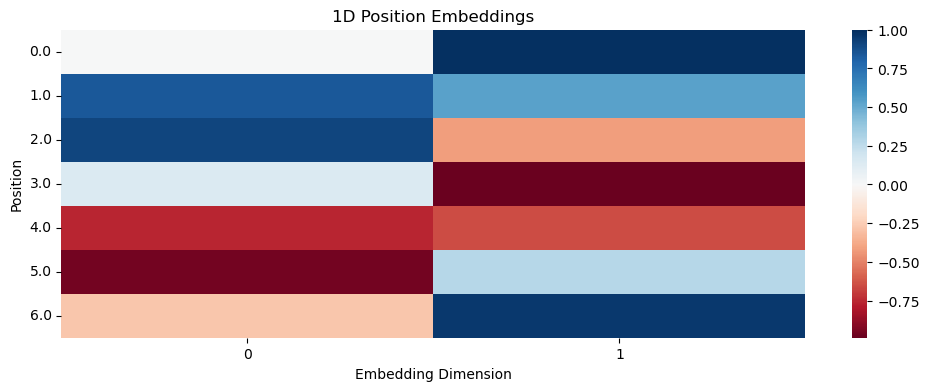

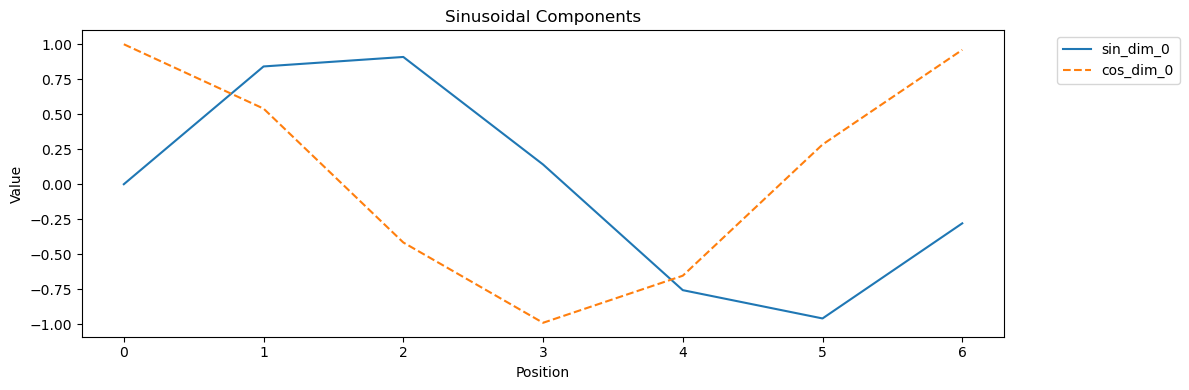

In [12]:
# coordinate_grid = np.arange(0, 2 * np.pi).squeeze()
# embeddings = get_1d_sincos_pos_embed_from_grid(embed_dim=2, coordinate_grid=coordinate_grid)
# visualize_embeddings(embeddings, coordinate_grid)

In [13]:
coordinate_grid = np.arange(0, 2 * np.pi).squeeze()
embeddings = get_1d_sincos_pos_embed_from_grid(embed_dim=8, coordinate_grid=coordinate_grid)
visualize_embeddings(embeddings, coordinate_grid)

In [14]:
coordinate_grid = np.arange(0, 2 * np.pi).squeeze()
embeddings = get_1d_sincos_pos_embed_from_grid(embed_dim=32, coordinate_grid=coordinate_grid)
visualize_embeddings(embeddings, coordinate_grid)

<!-- The unique encoding given to each position is given by the values for all the dimensions for that given position. Naturally, this can be extended to the 2d case as shown below -->

<!-- #### Implementation 2d -->

In [15]:
# import sys

# import numpy as np

# sys.path.append("../..")
# from src.annotated.positional_embedding import (
#     construct_coordinate_grid_2d,
#     get_1d_sincos_pos_embed_from_grid,
#     get_2d_sincos_pos_embed_from_grid,
# )

In [16]:
# # Grid size determines the domain of the positional embeddings
# # Embed dim determines the number of frequencies of the positional embeddings
# # Extend embeddings to 2d, but really it is just made up of reshaped 1d embeddings so instead of (N, D) where N=number of tokens, and D=embed_dim
# # it is now (H * W, D) where H = number of tokens in H, and W = number of tokens in W)
# grid_size = int(2 * np.pi) + 1
# grid_size_x = grid_size
# grid_size_y = grid_size
# coordinate_grid_2d = construct_coordinate_grid_2d(grid_size_x=grid_size_x, grid_size_y=grid_size_y)

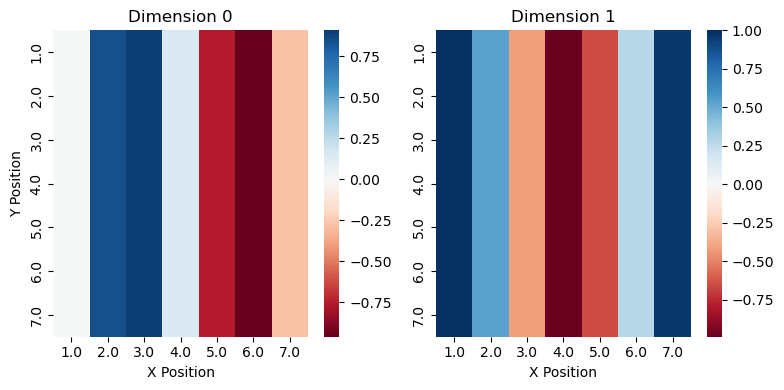

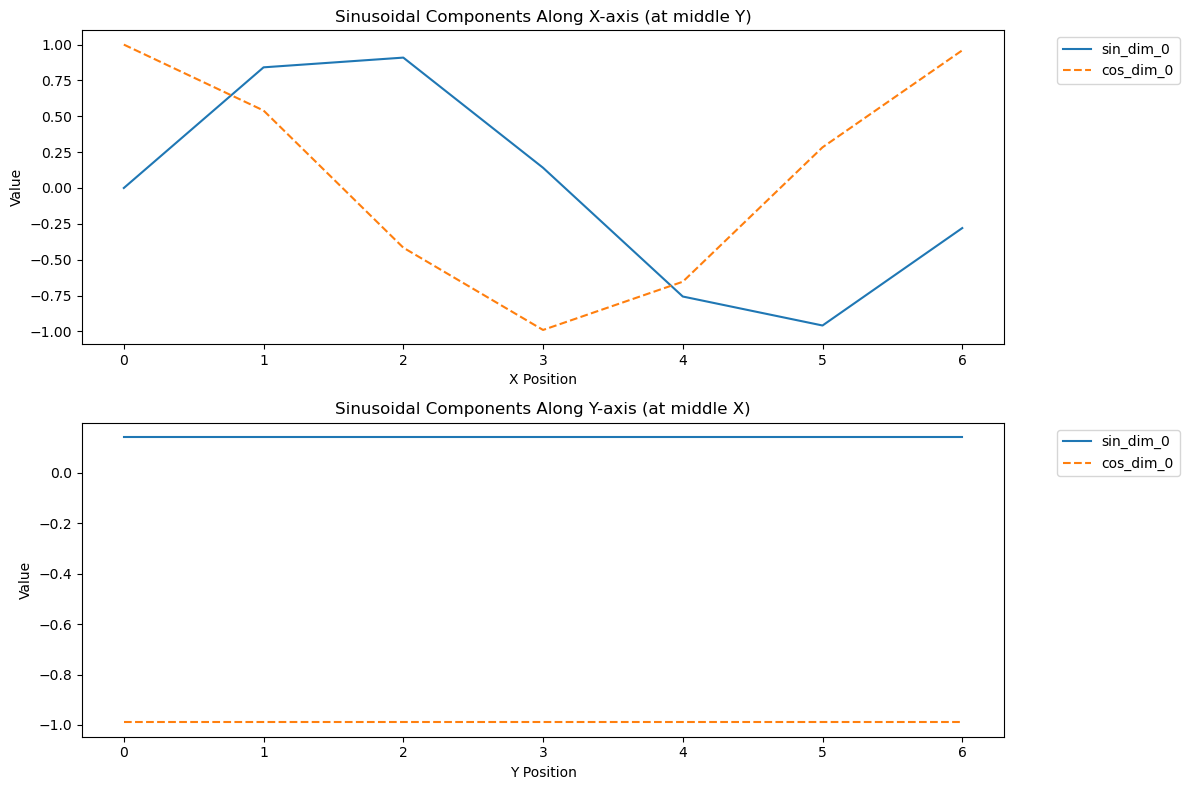

In [17]:
# # Lets see first the H embeddings
# embed_dim = 2
# coordinate_grid_h = coordinate_grid_2d[0]
# coordinate_h, coordinate_w = coordinate_grid_h.squeeze().shape
# embeddings = get_1d_sincos_pos_embed_from_grid(embed_dim=embed_dim, coordinate_grid=coordinate_grid_h)
# reshaped_embeddings = embeddings.reshape(coordinate_h, coordinate_w, embed_dim)
# visualize_embeddings(reshaped_embeddings, coordinate_grid_h)

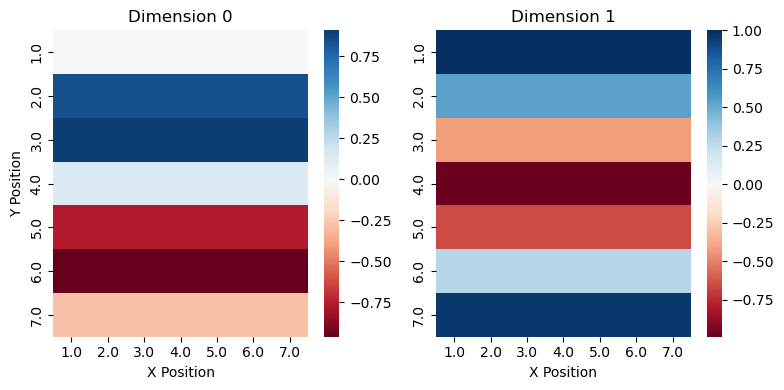

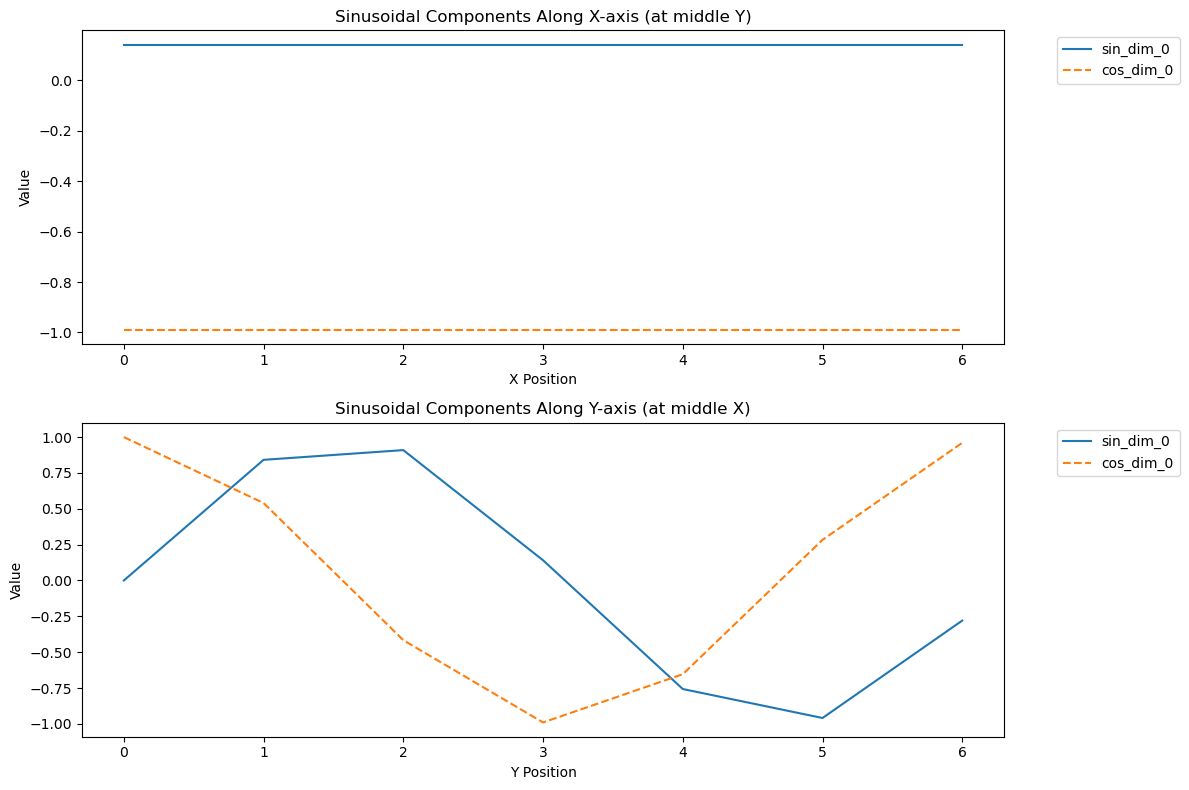

In [18]:
# # Then the W embeddings
# embed_dim = 2
# coordinate_grid_w = coordinate_grid_2d[1]
# coordinate_h, coordinate_w = coordinate_grid_w.squeeze().shape
# embeddings = get_1d_sincos_pos_embed_from_grid(embed_dim=embed_dim, coordinate_grid=coordinate_grid_w)
# reshaped_embeddings = embeddings.reshape(coordinate_h, coordinate_w, embed_dim)
# visualize_embeddings(reshaped_embeddings, coordinate_grid_w)

In [19]:
# # WLOG we can always reshape a 1d embedding into 2d thus get_2d_sincos_pos_embed_from_grid operates will reshape the embeddings from (H, W, embed_dim) -> (H * W, embed_dim)
# embed_dim_1d = 2
# embeddings = get_2d_sincos_pos_embed_from_grid(embed_dim_1d * 2, coordinate_grid_2d)
# assert embeddings.shape == (grid_size_y * grid_size_x, embed_dim_1d * 2)

<!-- ### Attention -->

<!-- ### Masking -->

In [31]:
# import torch

# from src.annotated.mask_generator import RandomMask as AnnotatedRandomMask
# from src.croco.models.masking import RandomMask as CrocoRandomMask


# def test_random_mask_equivalence():
#     # Test parameters
#     batch_size = 4
#     num_patches = 196
#     mask_ratio = 0.75

#     # Create dummy input
#     x = torch.randn(batch_size, num_patches, 32)  # 32 is arbitrary feature dim

#     # Initialize both implementations
#     croco_mask = CrocoRandomMask(num_patches, mask_ratio)
#     annotated_mask = AnnotatedRandomMask(num_patches, mask_ratio)

#     # Generate masks using both implementations
#     torch.manual_seed(42)  # Set seed for reproducibility
#     croco_output = croco_mask(x)

#     torch.manual_seed(42)  # Reset seed
#     annotated_output = annotated_mask(x)

#     # Print results
#     print(f"Shapes match: {croco_output.shape == annotated_output.shape}")
#     print(f"Expected shape: {(batch_size, num_patches)}")
#     print(f"Actual shape: {croco_output.shape}")
#     print(f"\nMasks are identical: {torch.all(croco_output == annotated_output)}")

#     expected_masks = int(mask_ratio * num_patches)
#     print(f"\nExpected masks per sample: {expected_masks}")
#     print(f"Actual masks per sample (Croco): {croco_output.sum(dim=1)}")
#     print(f"Actual masks per sample (Annotated): {annotated_output.sum(dim=1)}")


# # Run the test
# test_random_mask_equivalence()

Shapes match: True
Expected shape: (4, 196)
Actual shape: torch.Size([4, 196])

Masks are identical: True

Expected masks per sample: 147
Actual masks per sample (Croco): tensor([147, 147, 147, 147])
Actual masks per sample (Annotated): tensor([147, 147, 147, 147])


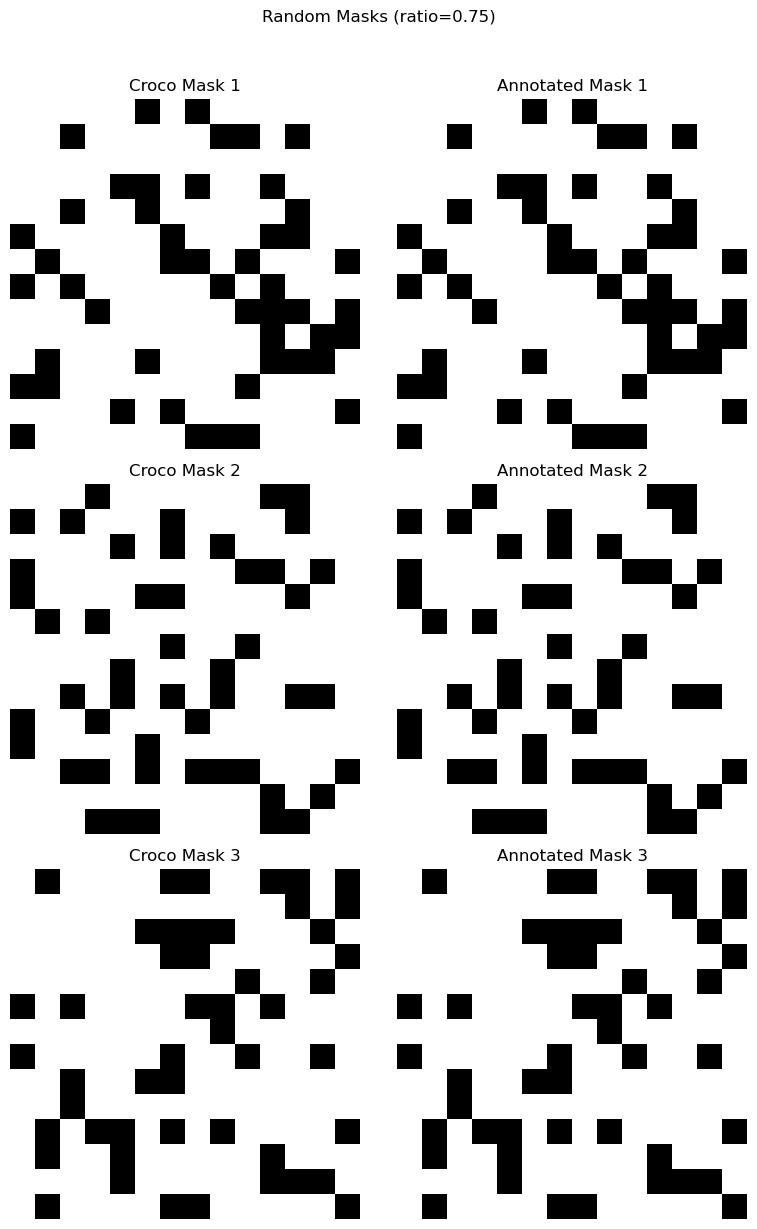

Masks are identical: True
Number of masked patches per sample: [147, 147, 147]
Expected number of masked patches: 147


In [32]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# from src.annotated.mask_generator import RandomMask as AnnotatedRandomMask
# from src.croco.models.masking import RandomMask as CrocoRandomMask


# def visualize_masks(batch_size=2, num_patches=196, mask_ratio=0.75, seed=42):
#     """
#     Visualizes and compares masks from both RandomMask implementations.
#     """
#     # Verify num_patches is a perfect square
#     patch_side = int(num_patches**0.5)
#     assert patch_side * patch_side == num_patches, "num_patches must be a perfect square"

#     # Create dummy input
#     x = torch.randn(batch_size, num_patches, 32)

#     # Initialize both implementations
#     croco_mask = CrocoRandomMask(num_patches, mask_ratio)
#     annotated_mask = AnnotatedRandomMask(num_patches, mask_ratio)

#     # Generate masks
#     torch.manual_seed(seed)
#     croco_output = croco_mask(x)

#     torch.manual_seed(seed)
#     annotated_output = annotated_mask(x)

#     # Setup the plot
#     fig, axes = plt.subplots(batch_size, 2, figsize=(8, 4 * batch_size))
#     if batch_size == 1:
#         axes = axes.reshape(1, -1)

#     for i in range(batch_size):
#         # Reshape masks to square for visualization and convert to numpy
#         croco_mask_img = croco_output[i].reshape(patch_side, patch_side).cpu().numpy()
#         annotated_mask_img = annotated_output[i].reshape(patch_side, patch_side).cpu().numpy()

#         # Plot Croco mask
#         axes[i, 0].imshow(croco_mask_img, cmap="gray")
#         axes[i, 0].set_title(f"Croco Mask {i+1}")
#         axes[i, 0].axis("off")

#         # Plot Annotated mask
#         axes[i, 1].imshow(annotated_mask_img, cmap="gray")
#         axes[i, 1].set_title(f"Annotated Mask {i+1}")
#         axes[i, 1].axis("off")

#     plt.suptitle(f"Random Masks (ratio={mask_ratio})", y=1.02)
#     plt.tight_layout()
#     plt.show()

#     # Print statistics
#     print(f"Masks are identical: {torch.all(croco_output == annotated_output)}")
#     print(f"Number of masked patches per sample: {croco_output.sum(dim=1).int().tolist()}")
#     print(f"Expected number of masked patches: {int(mask_ratio * num_patches)}")


# # Example usage
# visualize_masks(batch_size=3, num_patches=196, mask_ratio=0.75)

<!-- ### Vision Transformer Encoder -->

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Patch size: (16, 16)
torch.Size([1, 196, 768])


IndexError: too many indices for tensor of dimension 1

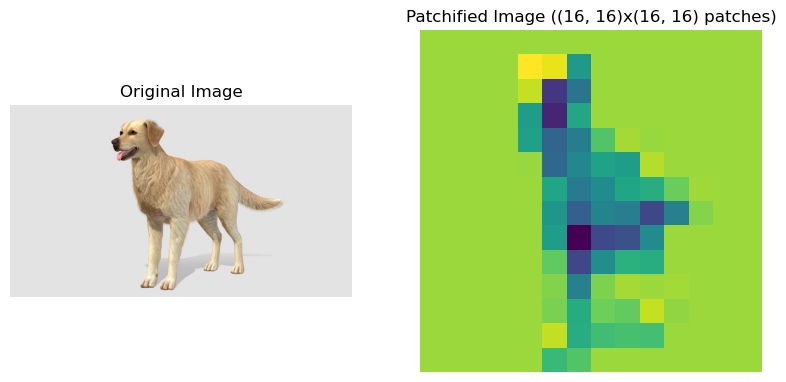

<Figure size 2000x4800 with 0 Axes>

In [10]:
# %load_ext autoreload
# %autoreload 2

# import sys

# sys.path.append("../../")

# from io import BytesIO

# import matplotlib.pyplot as plt
# import numpy as np
# import requests
# import torch
# from PIL import Image
# from torchvision import transforms

# from src.annotated.vision_transformer import VisionTransformerEncoder


# def get_attention_maps(model, x):
#     """Extract attention maps from vision transformer layers"""
#     attention_maps = []

#     def hook_fn(module, input, output):
#         # Extract attention weights from the output tuple
#         attention_maps.append(output.detach())

#     hooks = []
#     for block in model.blocks:
#         hooks.append(block.attn.register_forward_hook(hook_fn))

#     # Forward pass
#     model(x)

#     # Remove hooks
#     for hook in hooks:
#         hook.remove()

#     return attention_maps


# def visualize_transformer_internals(image_url, model):
#     # Download and preprocess image, with caching
#     import hashlib
#     import os

#     # Create cache directory if it doesn't exist
#     cache_dir = ".image_cache"
#     os.makedirs(cache_dir, exist_ok=True)

#     # Create filename from URL hash
#     url_hash = hashlib.md5(image_url.encode()).hexdigest()
#     cache_path = os.path.join(cache_dir, f"{url_hash}.jpg")

#     # Load from cache if exists, otherwise download
#     if os.path.exists(cache_path):
#         img = Image.open(cache_path)
#     else:
#         response = requests.get(image_url)
#         img = Image.open(BytesIO(response.content))
#         img.save(cache_path)
#     img_height, img_width = 224, 224

#     transform = transforms.Compose(
#         [
#             transforms.Resize((img_height, img_width)),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#         ]
#     )

#     x = transform(img).unsqueeze(0)

#     # 1. Visualize patchified image
#     patches, positional_encodings = model.patch_embed(x)  # [B, N, D]
#     patch_size = model.patch_embed.patch_size
#     print(f"Patch size: {patch_size}")
#     print(patches.shape)
#     num_patches_side = int(np.sqrt(patches.shape[1]))

#     plt.figure(figsize=(15, 5))
#     plt.subplot(131)
#     plt.imshow(img)
#     plt.title("Original Image")
#     plt.axis("off")

#     # Reshape patches for visualization
#     patch_vis = patches[0].reshape(num_patches_side, num_patches_side, -1)
#     patch_vis = patch_vis.mean(dim=-1).detach().cpu()

#     plt.subplot(132)
#     plt.imshow(patch_vis, cmap="viridis")
#     plt.title(f"Patchified Image ({patch_size}x{patch_size} patches)")
#     plt.axis("off")

#     # 2. Visualize attention maps
#     attention_maps = get_attention_maps(model, x)

#     plt.figure(figsize=(20, 4 * len(attention_maps)))
#     for i, attn_map in enumerate(attention_maps):
#         # Average attention weights across heads
#         avg_attn = attn_map.mean(dim=1)[0]  # [N, N]

#         # Reshape attention map to square grid
#         avg_attn = avg_attn[1:, 1:].reshape(num_patches_side, num_patches_side).cpu()  # Remove CLS token

#         plt.subplot(len(attention_maps), 1, i + 1)
#         plt.imshow(avg_attn, cmap="viridis")
#         plt.title(f"Layer {i+1} Attention Map")
#         plt.colorbar()

#     # 3. Visualize residual stream
#     activations = []

#     def hook_fn(module, input, output):
#         activations.append(output[0].detach())

#     hooks = []
#     for block in model.blocks:
#         hooks.append(block.register_forward_hook(hook_fn))

#     # Forward pass
#     model(x)

#     # Remove hooks
#     for hook in hooks:
#         hook.remove()

#     plt.figure(figsize=(20, 4 * len(activations)))
#     for i, activation in enumerate(activations):
#         # Take mean across feature dimension and remove CLS token
#         act_vis = activation[0, 1:].mean(dim=-1).reshape(num_patches_side, num_patches_side)

#         plt.subplot(len(activations), 1, i + 1)
#         plt.imshow(act_vis.cpu(), cmap="viridis")
#         plt.title(f"Layer {i+1} Residual Stream")
#         plt.colorbar()

#     plt.tight_layout()
#     plt.show()


# # Example usage
# image_url = "https://p.turbosquid.com/ts-thumb/Cz/KMmwgj/Dp/1/png/1704970250/1920x1080/fit_q99/e2d898a88de4aaf78f05316a8cc3ce6e4e8ac871/1.jpg"

# # Initialize model (adjust parameters as needed)
# model = VisionTransformerEncoder(
#     img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_layers=12, num_heads=12, mlp_ratio=4.0
# )

# visualize_transformer_internals(image_url, model)

In [ ]:
#